In [1]:
!pip install cmasher
!pip install jupyter-dash
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 3.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=87baf886abb08366c4d59d9f68fa8b8e47ef77b29e93b87f

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import cmasher as cmr
import umap.umap_ as umap
from itertools import product
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

In [3]:
import plotly.graph_objects as go
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

<ipython-input-3-584b937b2fde>:4: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-3-584b937b2fde>:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [4]:
df_full = pd.read_csv('/content/df_final.csv')
df_full = df_full.rename(columns={'raw_value_clean': 'raw_value'})

# Task 1

**Create at least 3 different types of statistical plots and 1 interactive plot to analyze your data. Use seaborn and plotly to visualize them. Draw conclusions and explain why the graphs are useful for analyzing your data.**

Count/NumHeavyAtoms 

Count/Bond Acceptor

Count/Bond Donors

Count/MolecularWeight

У нас часто повторяются какие-то соединения, можно сравнить одно значение для тех, кто часто встречается. И по типу измерения.  Бокс плоты


The first thing we can look at is the index of refraction. Its distribution. As you can see, we have a large tail of large values and a left-shifted distribution

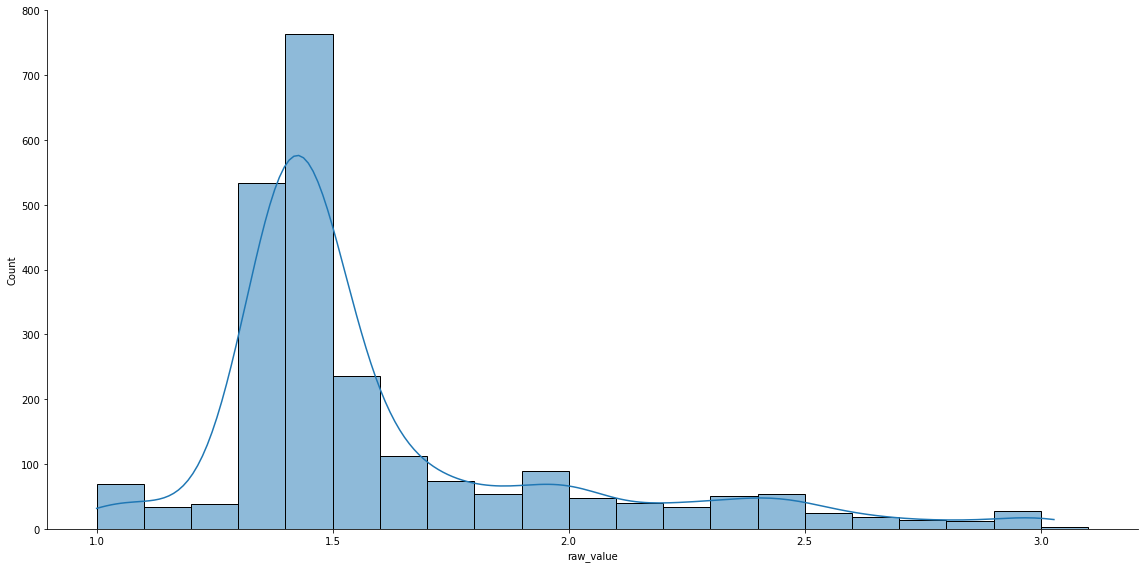

In [9]:
sns.displot(data=df_full, x='raw_value', kde=True, binwidth=0.1, height=8, aspect=2,)
plt.show()

For the sake of interest, you can look at some parameters among the descriptors.

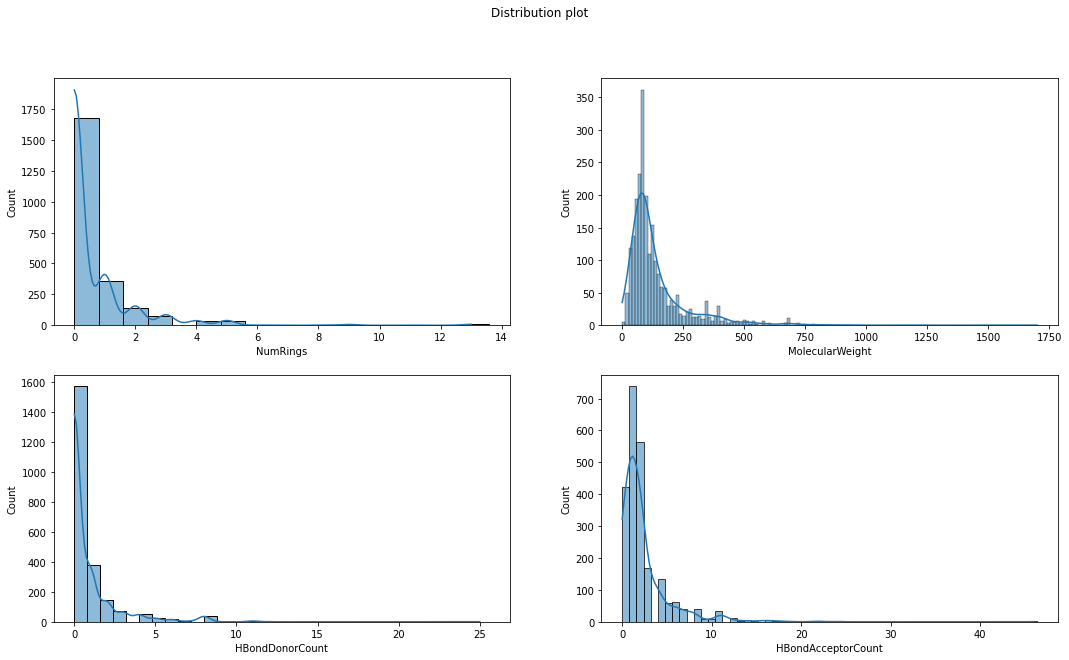

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Distribution plot')
sns.histplot(ax=axes[0, 0], data=df_full, x='NumRings', kde=True, binwidth=0.8)
sns.histplot(ax=axes[0, 1], data=df_full, x='MolecularWeight', kde=True)
sns.histplot(ax=axes[1, 0], data=df_full, x='HBondDonorCount', kde=True, binwidth=0.8)
sns.histplot(ax=axes[1, 1], data=df_full, x='HBondAcceptorCount', kde=True, binwidth=0.8)
plt.show()

It's interesting that these distribution are same refractive index distribution. We also have left-shift and heavy tail.

Also in original dataset refractive index was measured by several methods, we can see them in the pie chart. 

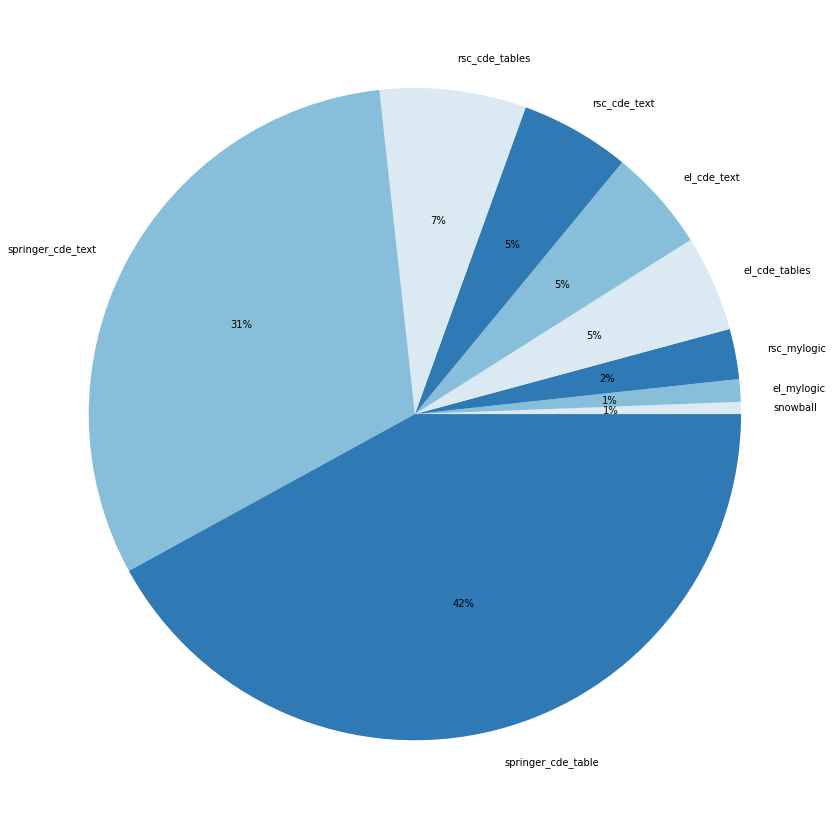

In [14]:
fig = plt.figure(figsize=(15,15))

count = list(df_full.groupby(['measurement_method'])['measurement_method'].count().sort_values())
colors = sns.color_palette('RdBu')[3:6]
label = list(df_full['measurement_method'].unique())
plt.pie(count, labels = label, colors = colors, autopct='%.0f%%')
plt.show()

For interactive plot we can investigate some dependencies between descriptors, which are obviosly not the same parameters of molecules. For example 

In [15]:
fig = px.scatter(df_full, x="NumHeavyAtoms", y="NumValenceElectrons", hover_name="Name")

app = JupyterDash(__name__)

app.layout = html.Div([dcc.Graph(figure=fig)])

app.run_server(mode='inline') 

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>

# Task 2

**Perform statistical tests for one categorical variable and multiple numeric descriptors. Draw conclusions and interpret your results.**

Let's analyze refraction index mesarement method. Ia there difference between them?

In [16]:
df_stat = df_full.dropna(subset=['measurement_method', 'raw_value'])

Check distribution for index, we remember that it left-shifted and has heavy tail. But Shapiro test shows that it's not normal.

In [17]:
data = df_stat.loc[:,'raw_value']
stat, p = shapiro(data)
print('stat={0:.3f}, p={0:.3f}' .format(stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.791, p=0.791
Probably not Gaussian


If we compare just two methods, we can see that is no difference here

In [18]:
data1 = df_stat[(df_stat.measurement_method == 'rsc_cde_text')]['raw_value']
data2 = df_stat[(df_stat.measurement_method == 'springer_cde_text')]['raw_value']
stat, p = ttest_ind(data1, data2)
print('stat={0:.3f}, p={0:.3f}'.format(stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=0.252, p=0.252
Probably the same distribution


Also it's the same for 3 methods.

In [19]:
data1 = df_stat[(df_stat.measurement_method == 'el_cde_text')]['raw_value']
data2 = df_stat[(df_stat.measurement_method == 'springer_cde_text')]['raw_value']
data3 = df_stat[(df_stat.measurement_method == 'rsc_cde_text')]['raw_value']
stat, p = f_oneway(data1, data2, data3)
print('stat={0:.3g}, p={0:.3g}'.format(stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=0.347, p=0.347
Probably the same distribution


# Task 3

**Calculate correlation coefficients for your dataset and investigate multicollinearity. Visualize and interpret your results.**

In our dataset we have a lot of descriptors, for visualization we use first few. In interactive heatmap ypu can in zoom and see value of coeffisients more clearly 

In [5]:
df_corr = df_full.select_dtypes(include = ['float', 'int']).corr(method='spearman')

Because of large dataset, before visualisation we drop some columns analysing table

In [6]:
triangle = df_corr.abs().where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
triangle

<ipython-input-6-8e8181dac3fd>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  triangle = df_corr.abs().where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))


,measurement_error,raw_value,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds_x,NumHBD,NumHBA,NumHeavyAtoms,...,piPC1,piPC10,piPC2,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9
measurement_error,NaN,0.052842,0.073570,0.072662,0.078600,0.095268,0.033511,0.092933,0.083366,0.039473,...,0.045964,0.096500,0.049523,0.049750,0.045986,0.062921,0.074567,0.084503,0.108611,0.091430
raw_value,NaN,NaN,0.136646,0.136362,0.008992,0.162795,0.138617,0.160981,0.006249,0.109688,...,0.038590,0.009594,0.051854,0.055068,0.026570,0.006195,0.011400,0.017552,0.014448,0.019962
exactmw,NaN,NaN,NaN,0.999189,0.435190,0.294199,0.599268,0.320406,0.416473,0.764351,...,0.721890,0.610634,0.719944,0.676571,0.693063,0.685467,0.712808,0.690397,0.665606,0.634146
amw,NaN,NaN,NaN,NaN,0.429213,0.291786,0.597132,0.318137,0.410227,0.758881,...,0.715255,0.610591,0.712484,0.673396,0.690042,0.682874,0.711897,0.689652,0.665330,0.633988
lipinskiHBA,NaN,NaN,NaN,NaN,NaN,0.507821,0.499158,0.503425,0.957418,0.545114,...,0.556848,0.418400,0.548495,0.404447,0.379481,0.352287,0.396756,0.408754,0.424184,0.411991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
piPC5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.943128,0.867372,0.756826,0.715736
piPC6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.922970,0.814560,0.767374
piPC7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.883856,0.830475
piPC8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.934028


Let's remove features with strong correlation

In [7]:
to_drop = [column for column in triangle.columns if any(triangle[column] > 0.95)]
df_full = df_full.drop(to_drop, axis=1)

The rest of the columns we can analyze in interactive heatmap (we plot only triangle with absolute correlation index)

In [8]:
# High correlated blocks with NumHeavyAtoms
group_1 = ['ATS0Z', 'ATS0dv', 'ATS0p', 'ATS1Z', 'ATS1dv', 'ATS2dv', 'ATS3dv', 'ATS4dv', 'ATS5dv', 'ATS6dv', 'ATS7Z', 'ATS7dv', 'ATSC0dv', 'ATSC0i', 'ATSC0v', 'ATS0dv', 'ATSC1d']
group_2 = ['BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW']
df_full['ATS_group'] = df_full[group_1].sum(axis=1) / len(group_1)
df_full['BCUT2D_group'] = df_full[group_2].sum(axis=1) / len(group_2)
df_full = df_full.drop(group_1 + group_2, axis=1)

In [9]:
# High corr with XStericQuadrupole3D
group_3 = ['Phi', 'kappa2', 'kappa1', 'chi2v', 'chi1v', 'chi0v', 'labuteASA']
df_full['XStericQuadrupole3D'] = df_full[group_3].sum(axis=1) / df_full['XStericQuadrupole3D']
df_full = df_full.drop(group_3, axis=1)

In [10]:
df_corr = df_full.select_dtypes(include = ['float', 'int']).corr(method='spearman')
triangle = df_corr.abs().where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))

<ipython-input-10-ea60b97ccd1a>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  triangle = df_corr.abs().where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))


In [12]:
fig = go.Figure()

fig.add_trace(
    go.Heatmap(
        x = triangle.columns,
        y = triangle.index,
        z = np.array(triangle),
        text=triangle.values,
        texttemplate='%{text:.2f}',
        colorscale = 'Viridis'
    )
)
fig.update_layout(
    autosize=False,
    width=1200,
    height=1200,)
app = JupyterDash(__name__)

app.layout = html.Div([dcc.Graph(figure=fig)])

app.run_server(mode='inline') 

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>

If we have a task and enough time, we check every correlated pairs higher 0.6 and choose the most appropriate feature.

In [13]:
df_full.to_csv("df_notcorr.csv", index=False)

# Task 4

**Choose one linear (except PCA) and one non-linear dimension reduction method. Run them on your data. It is preferable to use seaborn and plotly to visualize results. Justify the choice of the number of components / dimensions and explain them**

## Linear


## Non-linear

We can choose several non-linear algorithms for dimensions reduction. One of the most widely used techniques for visualization is t-SNE, but I don't want to use it, because using it correctly can be challenging for large dataset. Second technique is Umap. 

In [14]:
distances = ['minkowski', 'euclidean', 'manhattan']
neighbors = [2, 5, 15, 50, 100]
min_dist = [0.5, 0.8]

For dimension reduction we can't use None value, but it is unique value for molecules, we should either use kmeans filling or drop nans. Right now we wil drop

In [15]:
df = df_full.select_dtypes(include = ['float', 'int']).replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [16]:
scaler = MinMaxScaler()
df_scale = scaler.fit_transform(df)

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



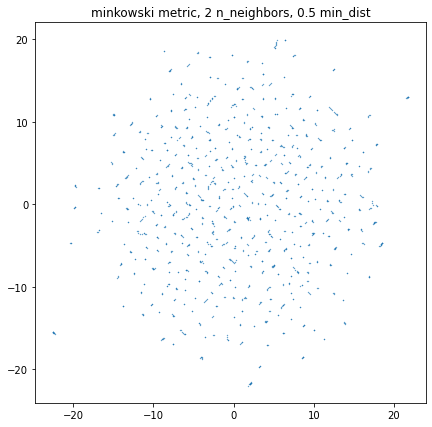

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



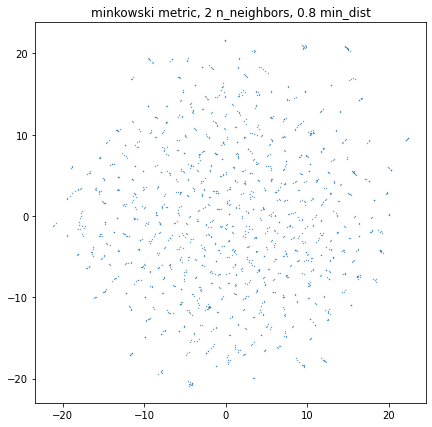

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



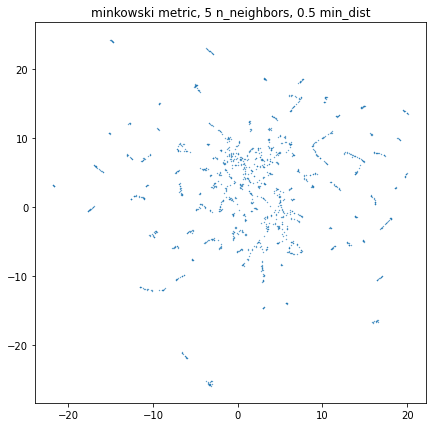

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



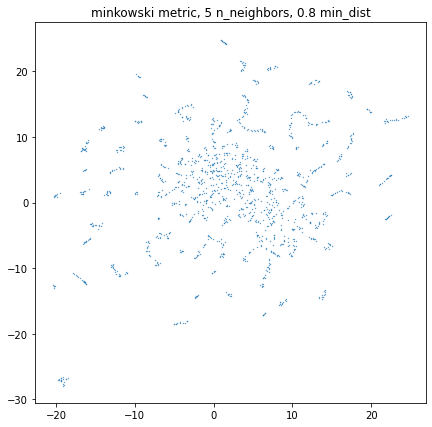

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



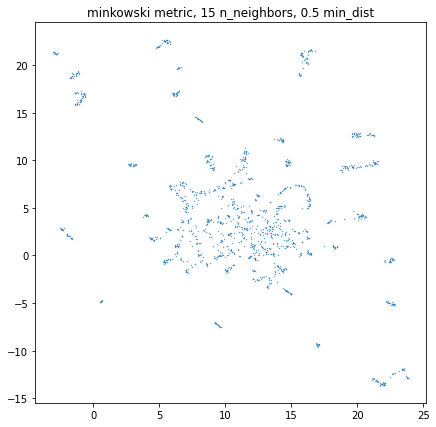

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



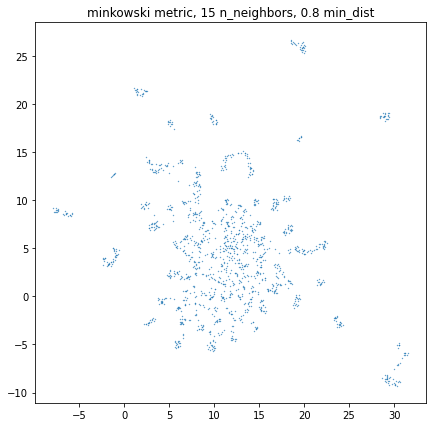

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



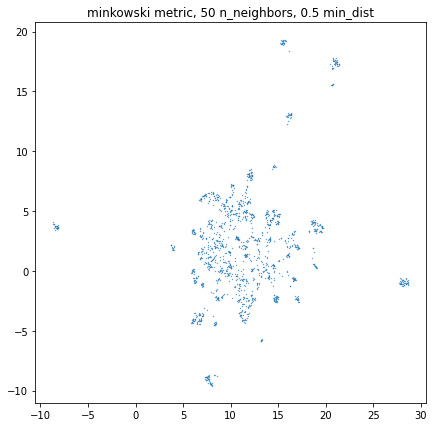

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



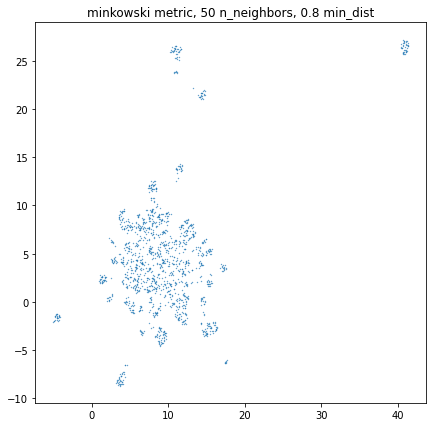

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



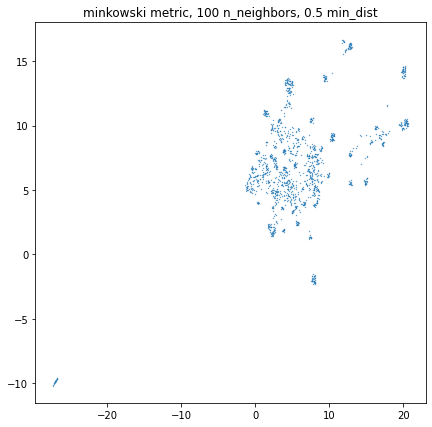

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



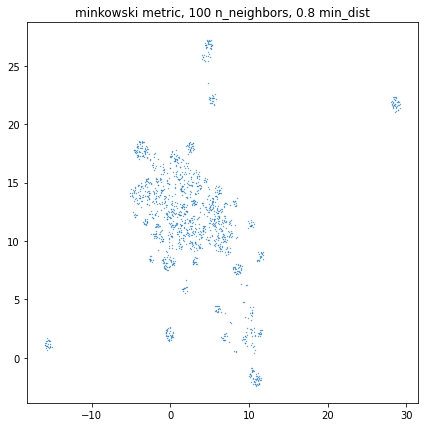

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



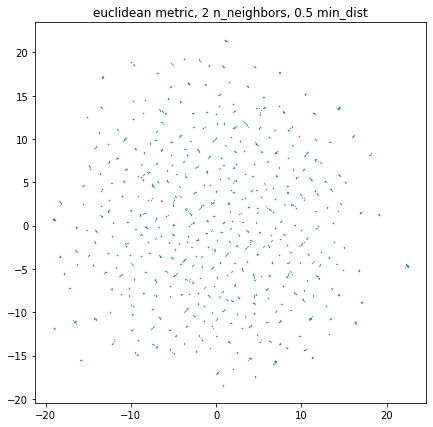

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



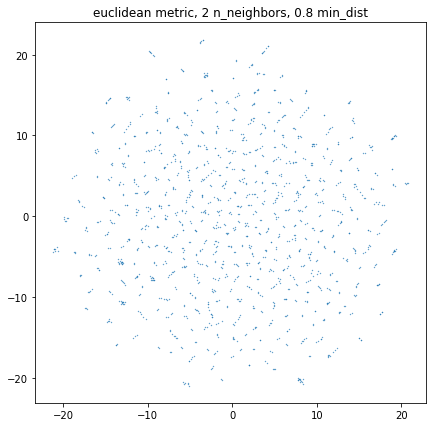

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



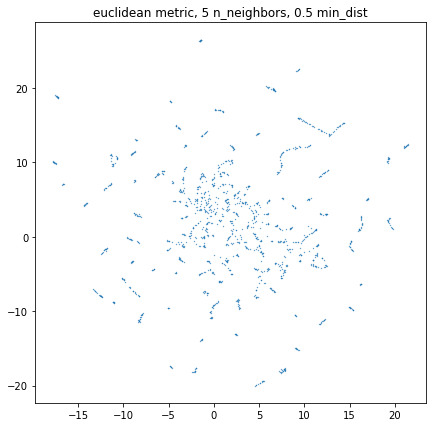

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



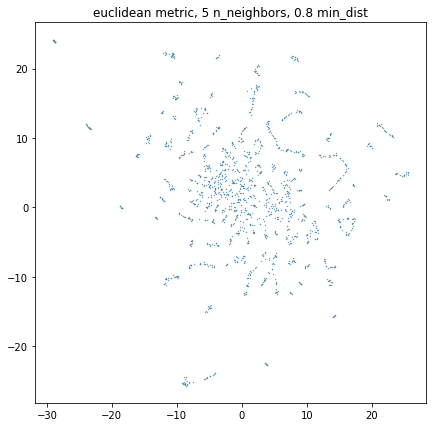

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



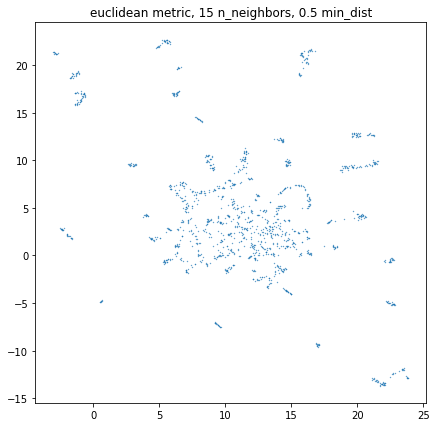

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



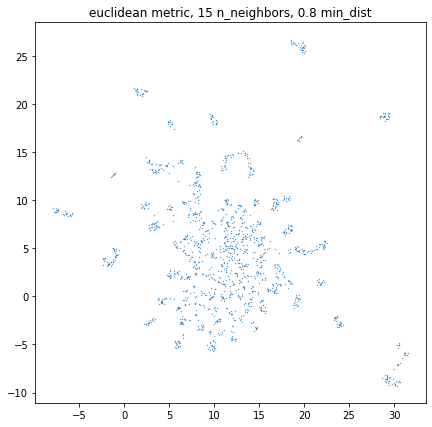

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



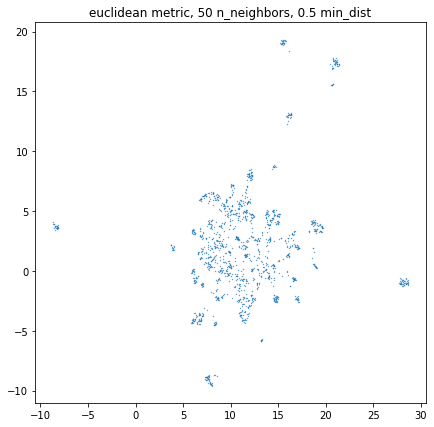

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



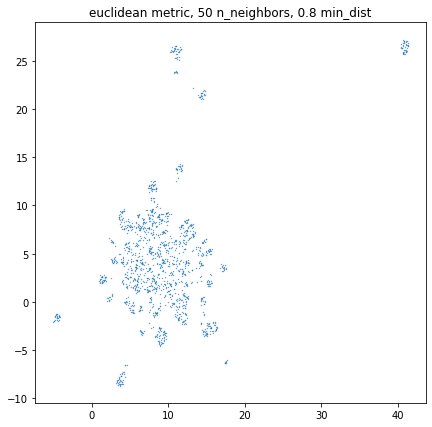

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



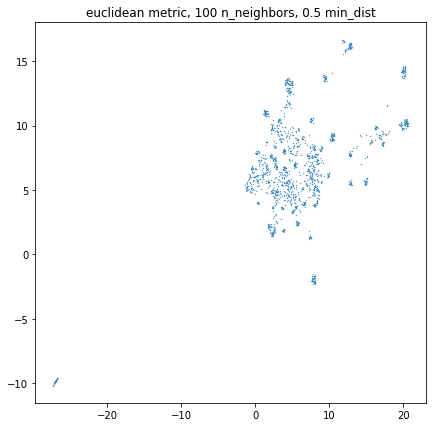

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



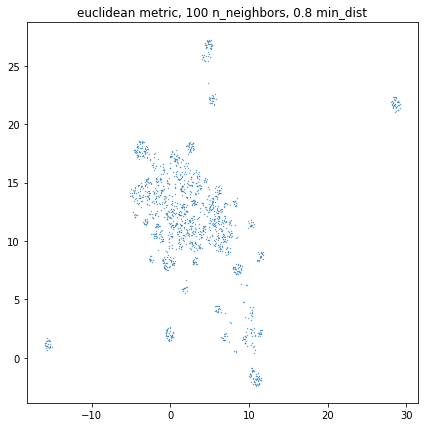

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



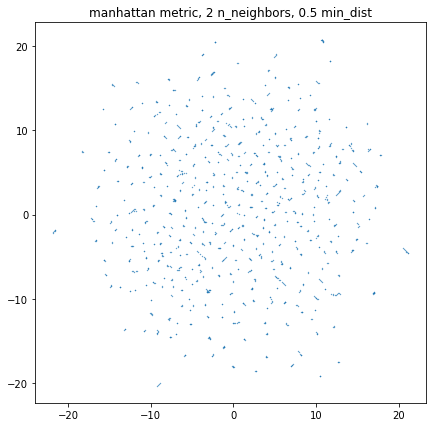

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



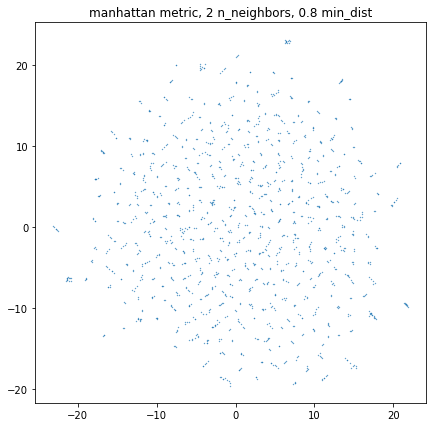

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



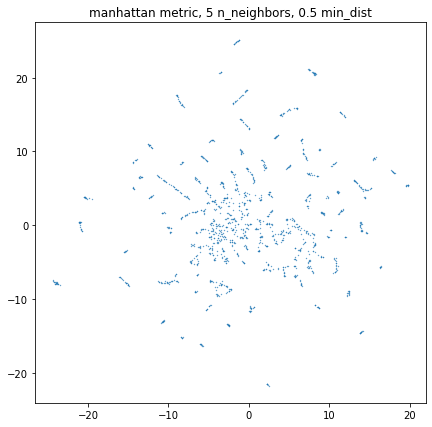

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



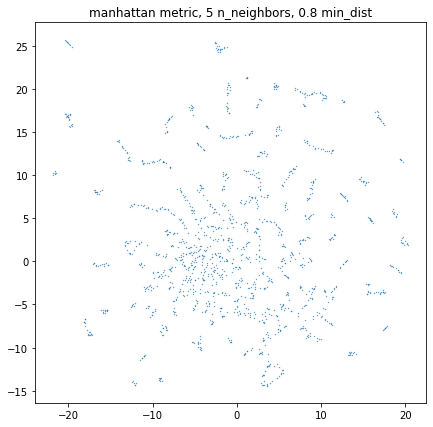

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



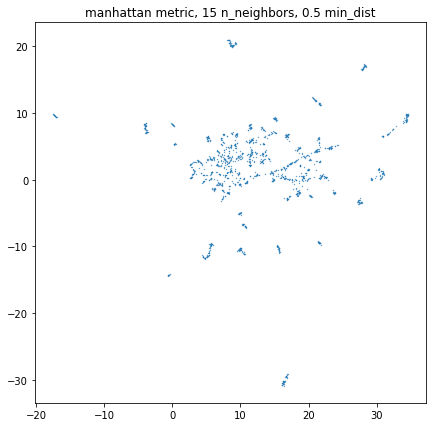

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



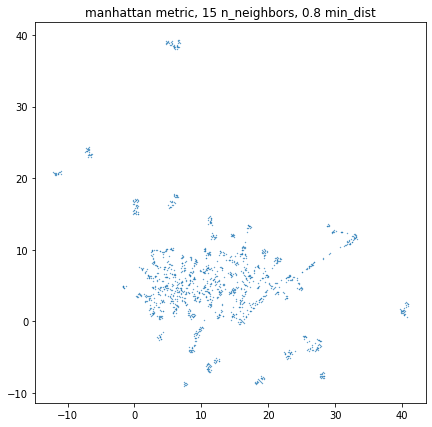

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



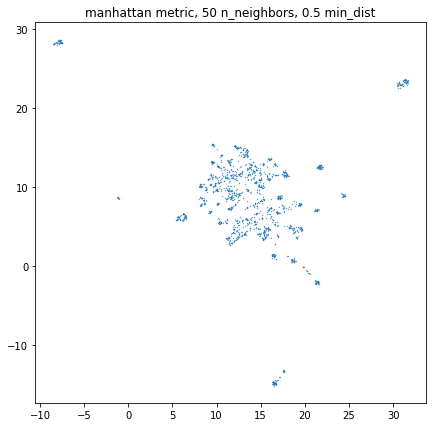

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



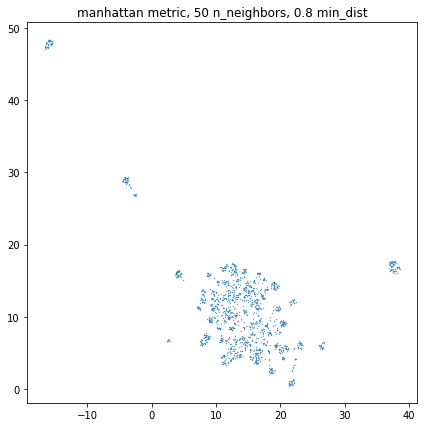

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



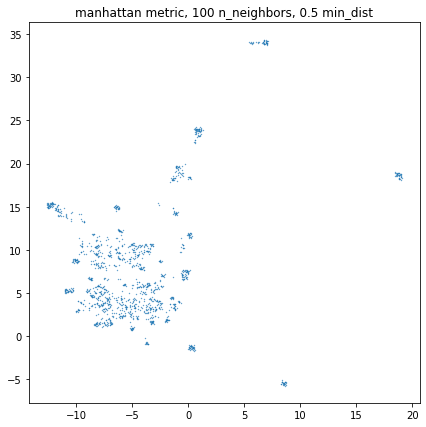

<ipython-input-17-027d3112bc91>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



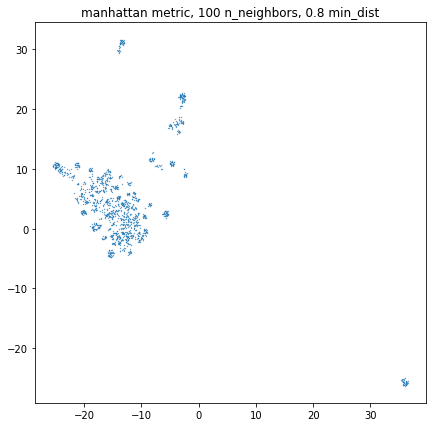

In [17]:
for dist, neigh, min_d in product(distances, neighbors, min_dist):
    clusterable_embedding = umap.UMAP(
        n_neighbors=neigh,
        min_dist=min_d, 
        n_components=2,
        random_state=42,
        metric=dist,
    ).fit_transform(df_scale)
    
    fig, axs = plt.subplots(figsize=(7, 7))
    plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')
    plt.title(f'{dist} metric, {neigh} n_neighbors, {min_d} min_dist')
    plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



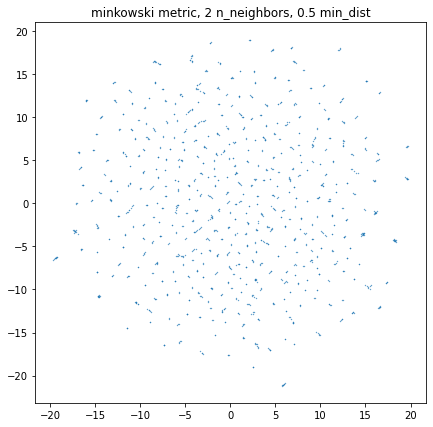

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



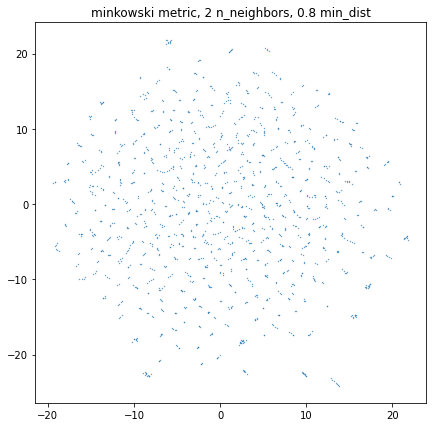

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



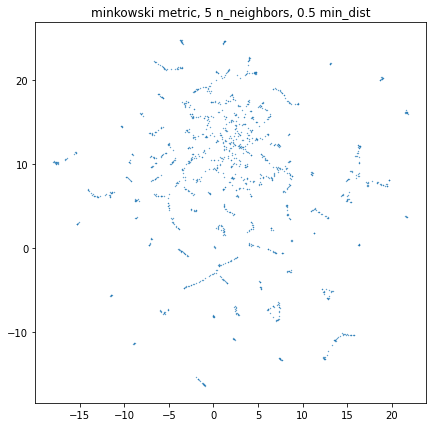

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



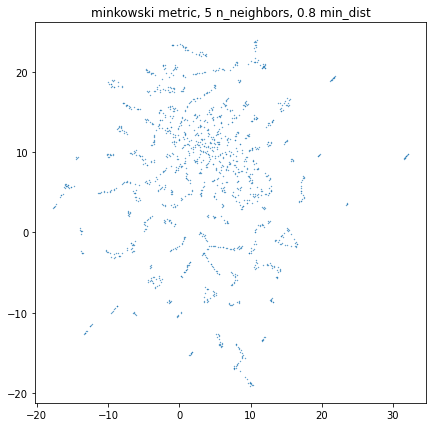

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



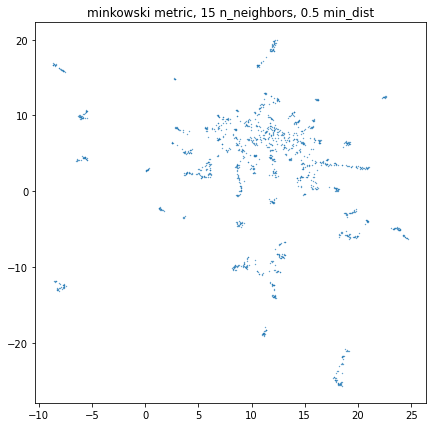

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



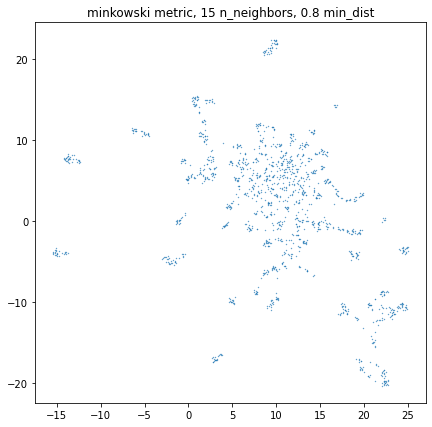

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



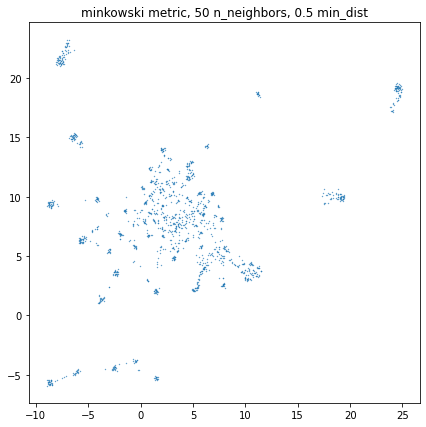

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



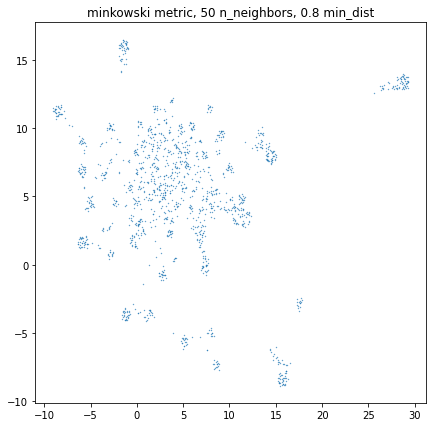

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



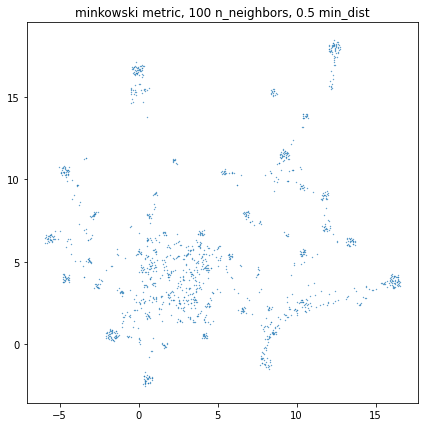

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



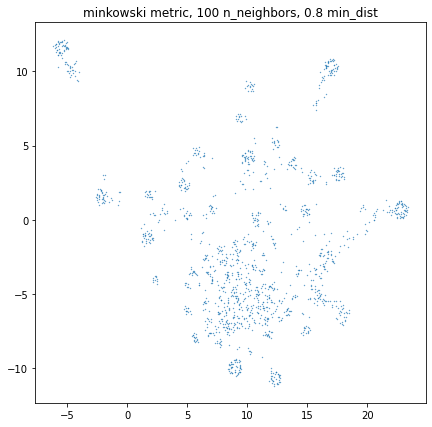

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



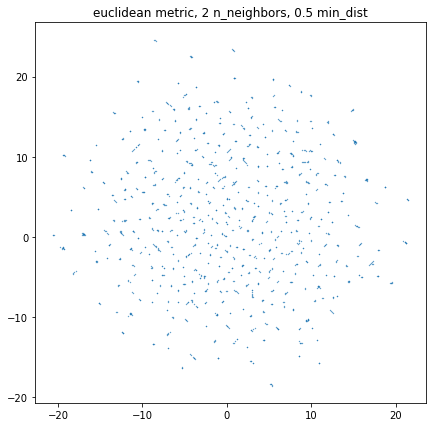

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



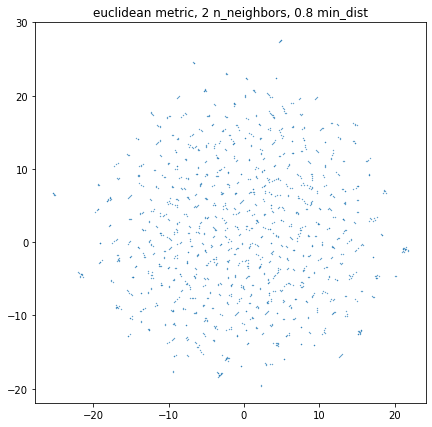

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



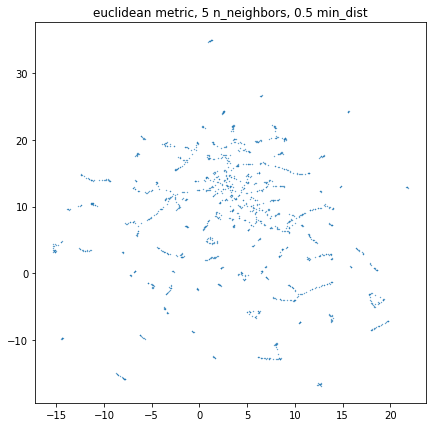

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



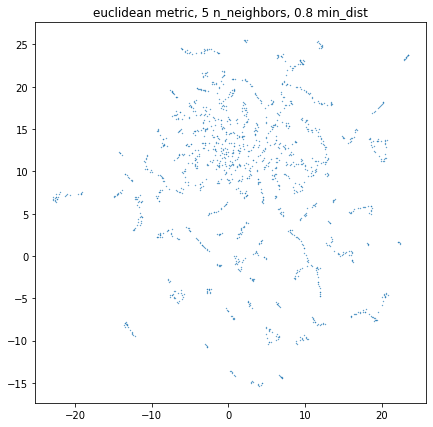

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



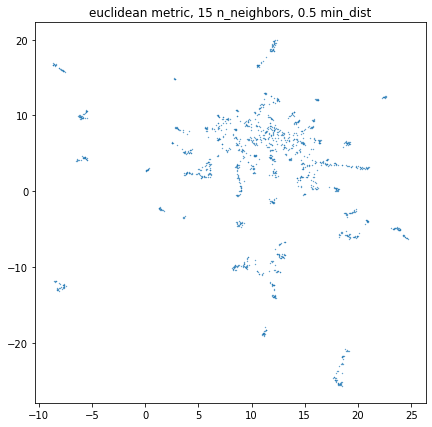

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



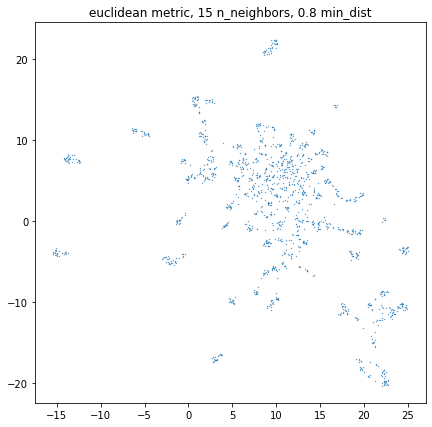

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



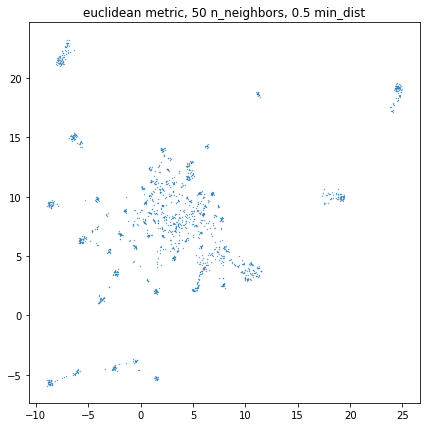

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



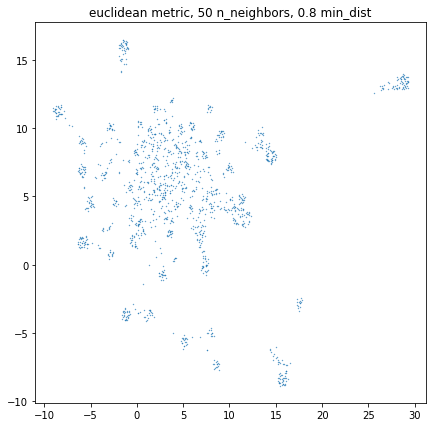

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



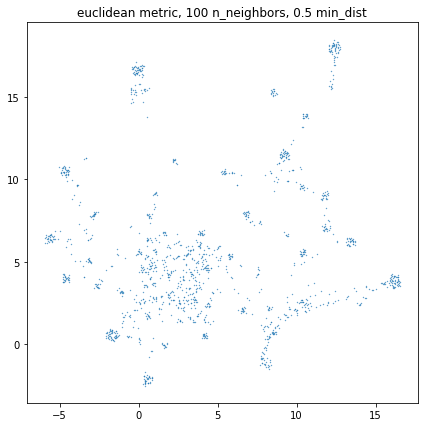

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



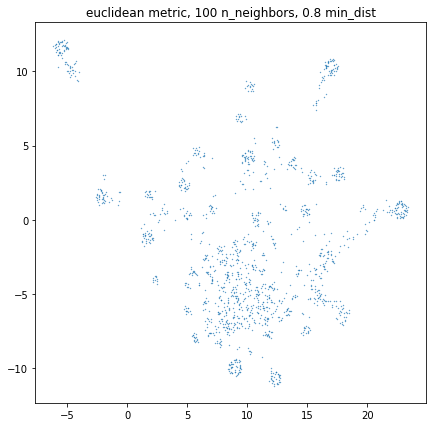

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



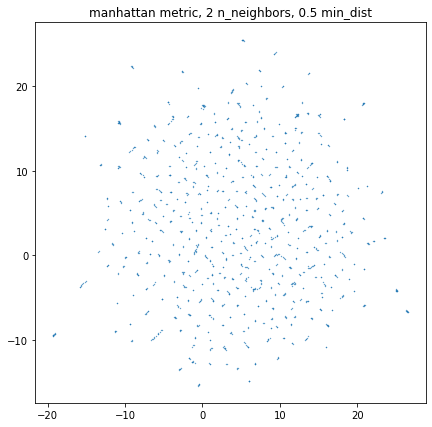

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



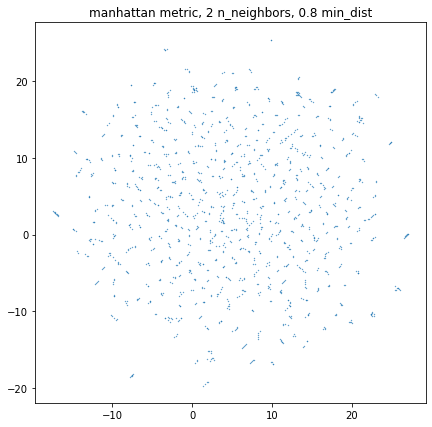

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



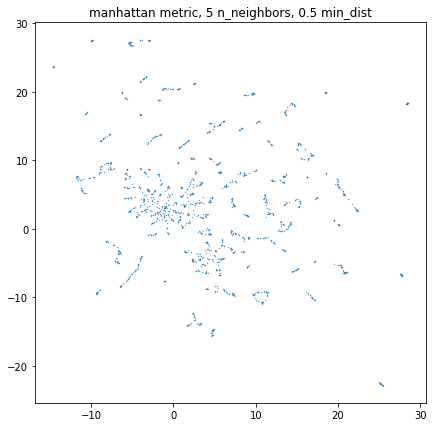

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



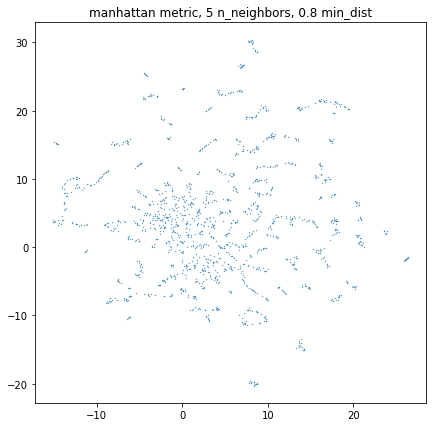

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



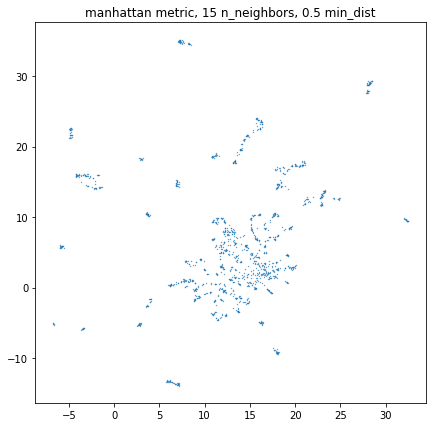

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



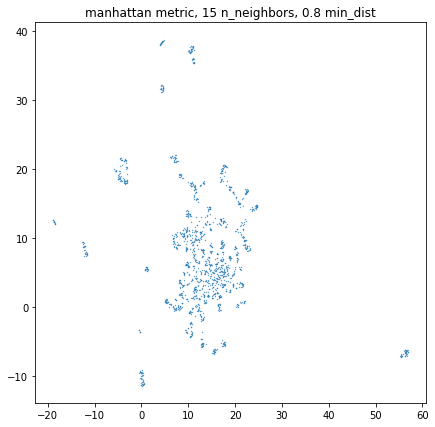

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



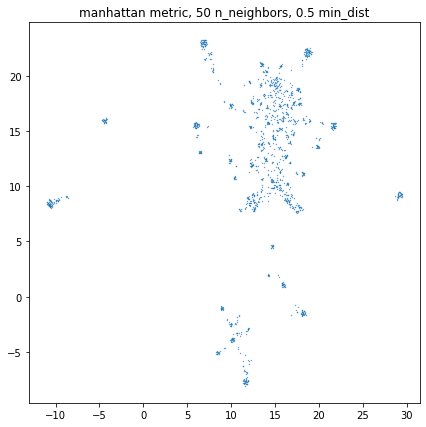

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



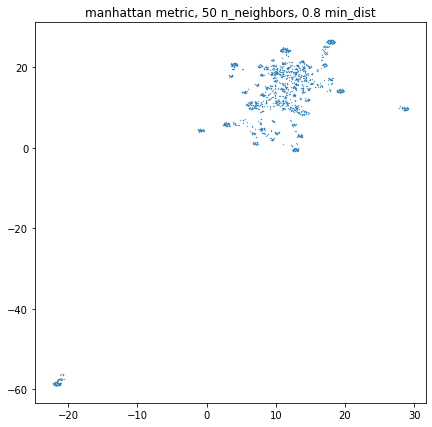

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



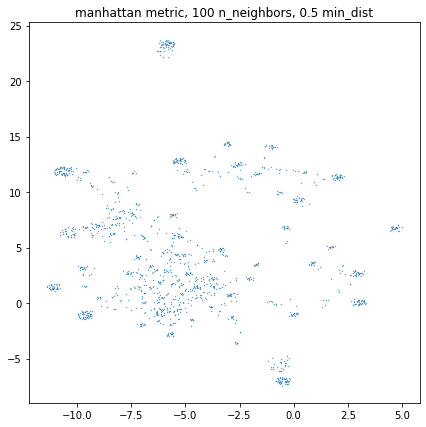

<ipython-input-18-c81fad6058d1>:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



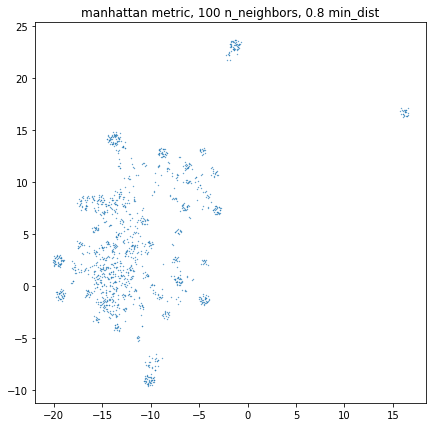

In [18]:
for dist, neigh, min_d in product(distances, neighbors, min_dist):
    clusterable_embedding = umap.UMAP(
        n_neighbors=neigh,
        min_dist=min_d, 
        n_components=2,
        random_state=42,
        metric=dist,
    ).fit_transform(df)
    
    fig, axs = plt.subplots(figsize=(7, 7))
    plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')
    plt.title(f'{dist} metric, {neigh} n_neighbors, {min_d} min_dist')
    plt.show()

It's to hard choose right reduction. Often people choose depends on metric of their model. But we chose for clustering.

<ipython-input-19-8b52bcbf9cf1>:10: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



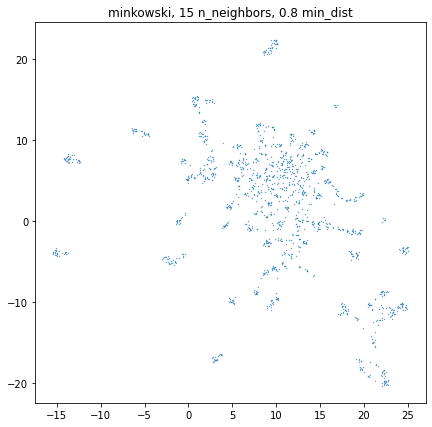

In [19]:
clusterable_embedding = umap.UMAP(
        n_neighbors=15,
        min_dist=0.8, 
        n_components=2,
        random_state=42,
        metric='minkowski',
    ).fit_transform(df)
    
fig, axs = plt.subplots(figsize=(7, 7))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')
plt.title(f'minkowski, 15 n_neighbors, 0.8 min_dist')
plt.show()